# Video Semantic Search with SigLIP 2

Search inside videos using natural language queries powered by **SigLIP 2** + **ChromaDB**

## Architecture

```
INDEXING PIPELINE (Offline)
┌─────────────────────────────────────────────────────────────────────────────┐
│  Video File ──► OpenCV ──► Frames + Timestamps ──► SigLIP2 ──► ChromaDB    │
│                 extract      (sampled @ 1fps)       embed      store        │
└─────────────────────────────────────────────────────────────────────────────┘

QUERY PIPELINE (Online)
┌─────────────────────────────────────────────────────────────────────────────┐
│  Text Query ──► SigLIP2 ──► Query Vector ──► ChromaDB ──► Top-K Results    │
│                 embed                         search      + timestamps      │
└─────────────────────────────────────────────────────────────────────────────┘
```

## Tech Stack

| Component | Technology | Purpose |
|-----------|------------|---------|
| Frame Extraction | OpenCV | Read video, extract frames at configurable FPS |
| Embedding Model | SigLIP 2 (google/siglip2-base-patch16-224) | Image & text embeddings in shared 768-dim space |
| Vector Database | ChromaDB | Store & search embeddings with HNSW index |
| Deep Learning | PyTorch + Transformers | Model inference with GPU acceleration |

## 1. Setup & Installation

In [1]:
# Install dependencies (uncomment if needed)
# %pip install torch transformers Pillow opencv-python chromadb numpy tqdm matplotlib
!uv add torch transformers Pillow opencv-python chromadb numpy tqdm matplotlib

Resolved 170 packages in 2ms
Audited 145 packages in 0.06ms


In [2]:
import cv2
import torch
import numpy as np
from pathlib import Path
from datetime import timedelta
from PIL import Image
from tqdm import tqdm
import chromadb
from transformers import AutoProcessor, AutoModel
import matplotlib.pyplot as plt

# Check device - prefer CUDA for faster inference
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

if device == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

e:\video-semantic-search\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda
GPU: NVIDIA GeForce RTX 3050 Ti Laptop GPU
VRAM: 4.0 GB


## 2. Configuration

All configurable parameters in one place with justifications.

In [3]:
# =============================================================================
# MODEL CONFIGURATION
# =============================================================================

# SigLIP 2 base model - fastest variant with 768-dim embeddings
# Alternatives: siglip2-large-patch16-384 (1024-dim), siglip2-so400m-patch14-384 (1152-dim)
MODEL_NAME = "google/siglip2-base-patch16-224"

# Embedding dimension for base model (changes with model variant)
EMBEDDING_DIM = 768

# =============================================================================
# FRAME EXTRACTION CONFIGURATION  
# =============================================================================

# Sample rate in frames per second
# 1.0 = extract 1 frame every second (good balance of coverage vs storage)
# 2.0 = extract 2 frames per second (more granular, 2x storage)
# 0.5 = extract 1 frame every 2 seconds (less granular, half storage)
SAMPLE_RATE = 1.0

# =============================================================================
# EMBEDDING CONFIGURATION
# =============================================================================

# Batch size for processing frames through the model
# 16 works well for 8GB VRAM with base model in float16
# Reduce to 8 if you encounter OOM errors
BATCH_SIZE = 16

# =============================================================================
# SEARCH CONFIGURATION
# =============================================================================

# Number of results to return from similarity search
TOP_K = 10

# =============================================================================
# STORAGE CONFIGURATION
# =============================================================================

# Directory structure
DATA_DIR = Path("./data")
VIDEOS_DIR = DATA_DIR / "videos"
DB_DIR = DATA_DIR / "chroma_db"

# Create directories
VIDEOS_DIR.mkdir(parents=True, exist_ok=True)
DB_DIR.mkdir(parents=True, exist_ok=True)

print(f"Model: {MODEL_NAME}")
print(f"Sample rate: {SAMPLE_RATE} fps")
print(f"Batch size: {BATCH_SIZE}")
print(f"Videos directory: {VIDEOS_DIR}")
print(f"Database directory: {DB_DIR}")

Model: google/siglip2-base-patch16-224
Sample rate: 1.0 fps
Batch size: 16
Videos directory: data\videos
Database directory: data\chroma_db


## 3. Load SigLIP 2 Model

Load the vision-language encoder with memory optimizations:
- **float16**: Reduces memory usage by 50% with minimal quality loss
- **SDPA**: Scaled Dot-Product Attention for efficient GPU computation

In [4]:
print(f"Loading model: {MODEL_NAME}")

# Load model with optimizations
# - torch_dtype=float16: Half precision for 50% memory savings
# - attn_implementation="sdpa": PyTorch's efficient attention
# - device_map="auto": Automatically place on GPU if available
model = AutoModel.from_pretrained(
    MODEL_NAME,
    dtype=torch.float16,
    attn_implementation="sdpa",
    device_map="auto"
).eval()  # Set to evaluation mode (disables dropout)


# Load processor (handles image preprocessing and text tokenization)
processor = AutoProcessor.from_pretrained(MODEL_NAME)


print(f"Model loaded successfully!")
print(f"Model device: {model.device}")
print(f"Image embedding dimension: {model.config.vision_config.hidden_size}")

Loading model: google/siglip2-base-patch16-224


Loading weights: 100%|██████████| 408/408 [00:02<00:00, 155.01it/s, Materializing param=vision_model.post_layernorm.weight]                      


Model loaded successfully!
Model device: cuda:0
Image embedding dimension: 768


## 4. Frame Extraction

Extract frames from video at a configurable sample rate using OpenCV.

**Key formula**: `timestamp_seconds = frame_index / fps`

In [5]:
def extract_frames(video_path: str, sample_rate: float = SAMPLE_RATE):
    """
    Extract frames from video at specified sample rate.
    
    Args:
        video_path: Path to video file
        sample_rate: Frames per second to extract (1.0 = 1 frame/sec)
    
    Returns:
        frames: List of RGB frames (numpy arrays)
        metadata: List of dicts with timestamp info
        video_info: Dict with video properties
    """
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        raise ValueError(f"Could not open video: {video_path}")
    
    # Get video properties
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    duration = total_frames / fps if fps > 0 else 0
    
    video_info = {
        "fps": fps,
        "total_frames": total_frames,
        "width": width,
        "height": height,
        "duration": duration
    }
    
    print(f"Video Info:")
    print(f"  - FPS: {fps:.2f}")
    print(f"  - Total Frames: {total_frames}")
    print(f"  - Resolution: {width}x{height}")
    print(f"  - Duration: {timedelta(seconds=int(duration))}")
    
    # Calculate sampling interval
    # If video is 30fps and sample_rate is 1.0, we take every 30th frame
    frame_interval = max(1, int(fps / sample_rate))
    expected_frames = total_frames // frame_interval
    print(f"  - Sampling: 1 frame every {frame_interval} frames ({sample_rate} fps)")
    print(f"  - Expected extracted frames: ~{expected_frames}")
    
    frames = []
    metadata = []
    frame_idx = 0
    
    pbar = tqdm(total=total_frames, desc="Extracting frames")
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        if frame_idx % frame_interval == 0:
            # Convert BGR (OpenCV default) to RGB (what models expect)
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame_rgb)
            
            # Calculate timestamp: frame_index / fps = seconds
            timestamp = frame_idx / fps
            
            metadata.append({
                "frame_idx": frame_idx,
                "timestamp": timestamp,
                "timestamp_str": str(timedelta(seconds=int(timestamp))),
            })
        
        frame_idx += 1
        pbar.update(1)
    
    pbar.close()
    cap.release()
    
    print(f"\nExtracted {len(frames)} frames")
    return frames, metadata, video_info


def get_frame_at_index(video_path: str, frame_idx: int):
    """Retrieve a single frame from video at specific index (for displaying results)."""
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
    ret, frame = cap.read()
    cap.release()
    
    if ret:
        return cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    return None

## 5. Embedding Functions

Generate embeddings using SigLIP 2:
- **Images**: Batch process frames through vision encoder
- **Text**: Encode queries through text encoder

Both produce vectors in the same 768-dimensional space, enabling cross-modal similarity search.

In [6]:
def embed_images(frames: list, batch_size: int = BATCH_SIZE):
    """
    Generate embeddings for a list of frames using SigLIP 2.
    
    Args:
        frames: List of RGB numpy arrays
        batch_size: Number of frames to process at once (reduce if OOM)
    
    Returns:
        embeddings: numpy array of shape (n_frames, EMBEDDING_DIM)
    """
    all_embeddings = []
    
    for i in tqdm(range(0, len(frames), batch_size), desc="Generating embeddings"):
        batch = frames[i:i + batch_size]
        
        # Process batch through the processor (resizes, normalizes)
        inputs = processor(images=batch, return_tensors="pt").to(model.device)
        
        with torch.no_grad():
            # Use get_image_features for image-only embedding
            # Returns BaseModelOutputWithPooling, access pooler_output for embeddings
            outputs = model.get_image_features(**inputs)
            embeddings = outputs.pooler_output
            
            # L2 normalize embeddings (required for cosine similarity)
            # This projects all vectors onto the unit sphere
            embeddings = embeddings / embeddings.norm(dim=-1, keepdim=True)
        
        all_embeddings.append(embeddings.cpu())
    
    return torch.cat(all_embeddings, dim=0).numpy()


def embed_text(query: str):
    """
    Generate embedding for a text query using SigLIP 2.
    
    Args:
        query: Natural language search query
    
    Returns:
        embedding: numpy array of shape (1, EMBEDDING_DIM)
    """
    # IMPORTANT: Use padding="max_length" and max_length=64 because SigLIP2 was trained this way
    inputs = processor(
        text=[query], 
        padding="max_length",  # Critical: model was trained with max_length padding
        max_length=64,         # SigLIP2 uses max_length=64
        return_tensors="pt"
    ).to(model.device)
    
    with torch.no_grad():
        # Use get_text_features for text-only embedding
        # Returns BaseModelOutputWithPooling, access pooler_output for embeddings
        outputs = model.get_text_features(**inputs)
        embedding = outputs.pooler_output
        
        # L2 normalize (same as images)
        embedding = embedding / embedding.norm(dim=-1, keepdim=True)
    
    return embedding.cpu().numpy()

## 6. ChromaDB Vector Database

Set up persistent vector storage with HNSW index for fast similarity search.

**Why ChromaDB?**
- Simple Python API
- Automatic HNSW indexing (O(log n) search)
- Persistent storage to disk
- Metadata filtering support

In [7]:
# Initialize ChromaDB with persistent storage
# Data is automatically saved to disk at DB_DIR
chroma_client = chromadb.PersistentClient(path=str(DB_DIR))

# Create or get collection for video frames
# Using cosine similarity (appropriate for normalized embeddings)
collection = chroma_client.get_or_create_collection(
    name="video_frames",
    metadata={"hnsw:space": "cosine"}  # Cosine distance for similarity search
)

print(f"Collection: {collection.name}")
print(f"Current frame count: {collection.count()}")


def get_database_stats():
    """Get statistics about the indexed database."""
    total_frames = collection.count()
    
    print("\nDatabase Statistics")
    print("=" * 40)
    print(f"Total indexed frames: {total_frames}")
    
    if total_frames > 0:
        # Get unique video IDs
        all_data = collection.get(include=["metadatas"])
        video_ids = set(m.get("video_id", "unknown") for m in all_data["metadatas"])
        print(f"Total videos: {len(video_ids)}")
        print(f"\nIndexed videos:")
        for v in video_ids:
            print(f"  - {v}")
    print("=" * 40)


def clear_database():
    """Clear all data from the collection (use with caution!)."""
    global collection
    chroma_client.delete_collection("video_frames")
    collection = chroma_client.create_collection(
        name="video_frames",
        metadata={"hnsw:space": "cosine"}
    )
    print("Database cleared!")

Collection: video_frames
Current frame count: 265


## 7. Video Indexing Pipeline

The main indexing function that orchestrates:
1. Frame extraction (OpenCV)
2. Embedding generation (SigLIP 2)
3. Vector storage (ChromaDB)

In [8]:
def index_video(video_path: str, video_id: str, sample_rate: float = SAMPLE_RATE):
    """
    Index a video into ChromaDB for semantic search.
    
    Args:
        video_path: Path to video file
        video_id: Unique identifier for this video (used in search results)
        sample_rate: Frames per second to extract
    
    Returns:
        num_frames: Number of frames indexed
    """
    print(f"\n{'='*60}")
    print(f"Indexing video: {video_id}")
    print(f"{'='*60}\n")
    
    # Step 1: Extract frames from video
    frames, metadata, video_info = extract_frames(video_path, sample_rate)
    
    if len(frames) == 0:
        raise ValueError("No frames extracted from video")
    
    # Step 2: Generate embeddings for all frames
    print("\nGenerating embeddings...")
    embeddings = embed_images(frames)
    print(f"Embeddings shape: {embeddings.shape}")
    
    # Step 3: Prepare data for ChromaDB
    # Create unique IDs for each frame
    ids = [f"{video_id}_frame_{m['frame_idx']}" for m in metadata]
    
    # Add video info to metadata
    for m in metadata:
        m["video_id"] = video_id
        m["video_path"] = str(video_path)
    
    # Step 4: Store in ChromaDB
    print("\nStoring in ChromaDB...")
    collection.add(
        ids=ids,
        embeddings=embeddings.tolist(),
        metadatas=metadata
    )
    
    print(f"\nSuccessfully indexed {len(frames)} frames from '{video_id}'")
    print(f"Total frames in database: {collection.count()}")
    
    return len(frames)

---

# Image & Document Search

Extending the pipeline to support **images** and **documents** alongside videos.

## Architecture

```
VISUAL CONTENT (SigLIP 2)
┌─────────────────────────────────────────────────────────────────────────────┐
│  Video ──► Frames ──► SigLIP 2 ──► visual_content collection                │
│  Image ──────────────► SigLIP 2 ──► visual_content collection                │
└─────────────────────────────────────────────────────────────────────────────┘

DOCUMENTS (E5-small)
┌─────────────────────────────────────────────────────────────────────────────┐
│  Document ──► Text Extraction ──► Chunking ──► E5-small ──► documents collection │
└─────────────────────────────────────────────────────────────────────────────┘
```

## Image Search

Index and search standalone images using the same SigLIP 2 model.

In [9]:
# =============================================================================
# IMAGE SEARCH FUNCTIONS
# =============================================================================

from PIL import Image as PILImage

# Directory for images
IMAGES_DIR = DATA_DIR / "images"
IMAGES_DIR.mkdir(parents=True, exist_ok=True)

SUPPORTED_IMAGE_EXTENSIONS = {".jpg", ".jpeg", ".png", ".webp", ".gif"}


def load_image(image_path: str) -> PILImage.Image:
    """Load an image file and convert to RGB."""
    img = PILImage.open(image_path)
    if img.mode != "RGB":
        img = img.convert("RGB")
    return img


def embed_single_image(image_path: str, model, processor):
    """Generate embedding for a single image."""
    img = load_image(image_path)
    
    inputs = processor(images=[img], return_tensors="pt").to(model.device)
    
    with torch.no_grad():
        output = model.get_image_features(**inputs)
        if hasattr(output, 'pooler_output'):
            embedding = output.pooler_output
        elif hasattr(output, 'last_hidden_state'):
            embedding = output.last_hidden_state[:, 0, :]
        else:
            embedding = output
        embedding = embedding / embedding.norm(dim=-1, keepdim=True)
    
    return embedding.cpu().numpy()


def index_image(image_path: str, image_id: str, model, processor, collection):
    """Index a single image into the collection."""
    img = PILImage.open(image_path)
    embedding = embed_single_image(image_path, model, processor)
    
    metadata = {
        "type": "image",
        "source_id": image_id,
        "source_path": str(image_path),
        "width": img.width,
        "height": img.height,
    }
    
    collection.add(
        ids=[f"image_{image_id}"],
        embeddings=embedding.tolist(),
        metadatas=[metadata]
    )
    
    return 1


def index_images_from_folder(folder_path: str, model, processor, collection):
    """Index all images from a folder."""
    folder = Path(folder_path)
    image_files = [f for f in folder.iterdir() 
                   if f.suffix.lower() in SUPPORTED_IMAGE_EXTENSIONS]
    
    indexed = 0
    for img_path in tqdm(image_files, desc="Indexing images"):
        try:
            image_id = img_path.stem
            index_image(str(img_path), image_id, model, processor, collection)
            indexed += 1
        except Exception as e:
            print(f"Error indexing {img_path}: {e}")
    
    return indexed


print("Image search functions defined!")

Image search functions defined!


## Document Search

Index and search documents using **multilingual-e5-small** (100+ languages, 384-dim embeddings).

Lightweight alternative to BGE-M3 (2.3GB → 470MB) with excellent quality-to-size ratio.

**Note:** E5 models use "query: " and "passage: " prefixes for optimal performance.

Supported formats: `.txt`, `.md`, `.pdf`, `.docx`

In [10]:
# =============================================================================
# DOCUMENT SEARCH - SETUP
# =============================================================================

# Install document dependencies if needed
# !uv add sentence-transformers pymupdf python-docx

from sentence_transformers import SentenceTransformer

# Document configuration
# multilingual-e5-small: 470MB, 384-dim, 100+ languages
# Lightweight alternative to BGE-M3 (2.3GB) with excellent multilingual support
# Note: E5 models use "query: " and "passage: " prefixes for optimal performance
DOCUMENT_MODEL_NAME = "intfloat/multilingual-e5-small"
DOCUMENTS_DIR = DATA_DIR / "documents"
DOCUMENTS_DIR.mkdir(parents=True, exist_ok=True)

SUPPORTED_DOC_EXTENSIONS = {".txt", ".md", ".pdf", ".docx"}
CHUNK_SIZE = 400  # words
CHUNK_OVERLAP = 50  # words

# Load multilingual-e5-small model
print("Loading multilingual-e5-small model for documents...")
doc_model = SentenceTransformer(DOCUMENT_MODEL_NAME)
print(f"Document model loaded! Embedding dim: {doc_model.get_sentence_embedding_dimension()}")

Loading BGE-M3 model for documents...


e:\video-semantic-search\.venv\Lib\site-packages\huggingface_hub\file_download.py:130: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\kirub\.cache\huggingface\hub\models--BAAI--bge-m3. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Loading weights: 100%|██████████| 391/391 [00:00<00:00, 472.46it/s, Materializing param=pooler.dense.weight]                  

Document model loaded! Embedding dim: 1024


In [11]:
# =============================================================================
# DOCUMENT TEXT EXTRACTION
# =============================================================================

def extract_text_from_txt(file_path: str) -> str:
    """Extract text from a plain text or markdown file."""
    with open(file_path, "r", encoding="utf-8") as f:
        return f.read()


def extract_text_from_pdf(file_path: str) -> str:
    """Extract text from a PDF file."""
    import fitz  # PyMuPDF
    
    doc = fitz.open(file_path)
    full_text = ""
    for page in doc:
        full_text += page.get_text() + "\n\n"
    doc.close()
    return full_text


def extract_text_from_docx(file_path: str) -> str:
    """Extract text from a DOCX file."""
    from docx import Document
    
    doc = Document(file_path)
    paragraphs = [p.text for p in doc.paragraphs if p.text.strip()]
    return "\n\n".join(paragraphs)


def extract_text(file_path: str) -> tuple[str, str]:
    """
    Extract text from a document file.
    Returns: (text, file_type)
    """
    path = Path(file_path)
    ext = path.suffix.lower()
    
    if ext in {".txt", ".md"}:
        return extract_text_from_txt(file_path), ext[1:]
    elif ext == ".pdf":
        return extract_text_from_pdf(file_path), "pdf"
    elif ext == ".docx":
        return extract_text_from_docx(file_path), "docx"
    else:
        raise ValueError(f"Unsupported file type: {ext}")


def chunk_text(text: str, chunk_size: int = CHUNK_SIZE, overlap: int = CHUNK_OVERLAP) -> list[dict]:
    """Split text into overlapping chunks."""
    words = text.split()
    chunks = []
    
    if len(words) == 0:
        return chunks
    
    step = max(1, chunk_size - overlap)
    
    for i in range(0, len(words), step):
        chunk_words = words[i:i + chunk_size]
        if len(chunk_words) < overlap and chunks:
            break
        
        chunk_text = " ".join(chunk_words)
        chunks.append({
            "chunk_idx": len(chunks),
            "text": chunk_text,
        })
    
    return chunks


print("Text extraction and chunking functions defined!")

Text extraction and chunking functions defined!


In [12]:
# =============================================================================
# DOCUMENT INDEXING & SEARCH
# =============================================================================

# Create separate collection for documents
doc_collection = chroma_client.get_or_create_collection(
    name="documents",
    metadata={"hnsw:space": "cosine"}
)

print(f"Document collection: {doc_collection.name}")
print(f"Documents indexed: {doc_collection.count()}")


def embed_texts(texts: list[str], model: SentenceTransformer, is_query: bool = False) -> list[list[float]]:
    """
    Generate embeddings for a list of texts.
    
    E5 models work best with prefixes:
    - "query: " for search queries
    - "passage: " for document chunks being indexed
    
    Args:
        texts: List of text strings
        model: multilingual-e5-small model
        is_query: If True, use "query: " prefix; otherwise use "passage: "
        
    Returns:
        list: List of embedding vectors
    """
    # Add appropriate prefix for E5 model
    prefix = "query: " if is_query else "passage: "
    prefixed_texts = [prefix + text for text in texts]
    
    embeddings = model.encode(
        prefixed_texts,
        normalize_embeddings=True,
        show_progress_bar=False
    )
    return embeddings.tolist()


def index_document(file_path: str, doc_id: str, model: SentenceTransformer, collection):
    """Index a document by chunking and embedding."""
    # Extract text
    text, file_type = extract_text(file_path)
    
    if not text.strip():
        raise ValueError("No text extracted from document")
    
    # Chunk text
    chunks = chunk_text(text)
    print(f"Created {len(chunks)} chunks from {doc_id}")
    
    # Generate embeddings
    chunk_texts = [c["text"] for c in chunks]
    embeddings = embed_texts(chunk_texts, model)
    
    # Store in ChromaDB
    ids = [f"{doc_id}_chunk_{c['chunk_idx']}" for c in chunks]
    
    metadatas = []
    for chunk in chunks:
        metadatas.append({
            "type": "document",
            "doc_id": doc_id,
            "doc_path": str(file_path),
            "file_type": file_type,
            "chunk_idx": chunk["chunk_idx"],
            "text": chunk["text"][:500],
        })
    
    collection.add(
        ids=ids,
        embeddings=embeddings,
        metadatas=metadatas
    )
    
    return len(chunks)


def search_documents(query: str, model: SentenceTransformer, collection, top_k: int = 5):
    """Search for document chunks matching the query."""
    if collection.count() == 0:
        return []
    
    # Embed query with "query: " prefix for E5 model
    query_embedding = embed_texts([query], model, is_query=True)
    
    results = collection.query(
        query_embeddings=query_embedding,
        n_results=top_k,
        include=["metadatas", "distances"]
    )
    
    search_results = []
    for i in range(len(results["ids"][0])):
        meta = results["metadatas"][0][i]
        distance = results["distances"][0][i]
        
        search_results.append({
            "rank": i + 1,
            "doc_id": meta["doc_id"],
            "file_type": meta.get("file_type", ""),
            "chunk_idx": meta["chunk_idx"],
            "text": meta.get("text", ""),
            "score": 1 - distance,
        })
    
    return search_results


print("Document indexing and search functions defined!")

Document collection: documents
Documents indexed: 0
Document indexing and search functions defined!


## Demo: Image & Document Search

Test the new image and document search capabilities.

In [23]:
# =============================================================================
# DEMO: Index an Image
# =============================================================================

image_path = "data/images/image-1.jpg"

if Path(image_path).exists():
    index_image(image_path, "sample_image", model, processor, collection)
    print("Image indexed!")

print(f"Images directory: {IMAGES_DIR}")
print(f"Place images here and run the indexing functions above")

Image indexed!
Images directory: data\images
Place images here and run the indexing functions above


In [24]:
# =============================================================================
# DEMO: Index a Document
# =============================================================================

# To index a document, place it in data/documents/ and run:
# index_document("data/documents/my_doc.pdf", "my_doc", doc_model, doc_collection)

# Example (uncomment if you have a document):
doc_path = "data/documents/document-1.pdf"
if Path(doc_path).exists():
    chunks = index_document(doc_path, "sample_doc", doc_model, doc_collection)
    print(f"Document indexed with {chunks} chunks!")

print(f"Documents directory: {DOCUMENTS_DIR}")
print(f"Place documents (.txt, .md, .pdf, .docx) here and run the indexing functions above")

Created 2 chunks from sample_doc
Document indexed with 2 chunks!
Documents directory: data\documents
Place documents (.txt, .md, .pdf, .docx) here and run the indexing functions above


## 8. Search Functions

Search indexed videos using natural language queries.

In [32]:
def search(query: str, top_k: int = TOP_K):
    """
    Search for frames matching the text query.
    
    Args:
        query: Natural language search query (e.g., "a person writing on whiteboard")
        top_k: Number of results to return
    
    Returns:
        results: List of dicts with video_id, timestamp, score, etc.
    """
    print(f"\nSearching for: '{query}'")
    
    # Embed the query text
    query_embedding = embed_text(query)
    
    # Search ChromaDB
    results = collection.query(
        query_embeddings=query_embedding.tolist(),
        n_results=top_k,
        include=["metadatas", "distances"]
    )
    
    # Format results
    search_results = []
    for i in range(len(results["ids"][0])):
        meta = results["metadatas"][0][i]
        distance = results["distances"][0][i]
        
        # Convert cosine distance to similarity score
        # ChromaDB returns distance (0 = identical, 2 = opposite)
        # We convert to similarity (1 = identical, -1 = opposite)
        score = 1 - distance
        
        search_results.append({
            "rank": i + 1,
            "video_id": meta["video_id"],
            "video_path": meta.get("video_path", ""),
            "timestamp": meta["timestamp"],
            "timestamp_str": meta["timestamp_str"],
            "frame_idx": meta["frame_idx"],
            "score": score,
        })
    
    print(f"Found {len(search_results)} results\n")
    return search_results


def display_search_results(results, max_display: int = 5):
    """
    Display search results with frame thumbnails.
    
    Args:
        results: List of result dicts from search()
        max_display: Maximum number of results to display
    """
    if not results:
        print("No results to display")
        return
    
    # Print text results
    print("Results:")
    print("-" * 70)
    for r in results[:max_display]:
        print(f"#{r['rank']} | {r['video_id']} | Time: {r['timestamp_str']} | Score: {r['score']:.4f}")
    print("-" * 70)
    
    # Load and display frames
    frames = []
    titles = []
    
    for r in results[:max_display]:
        frame = get_frame_at_index(r["video_path"], r["frame_idx"])
        if frame is not None:
            frames.append(frame)
            titles.append(f"#{r['rank']} {r['timestamp_str']}\nScore: {r['score']:.3f}")
    
    if frames:
        # Create figure with subplots
        n = len(frames)
        cols = min(n, 5)
        rows = (n + cols - 1) // cols
        
        fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
        if n == 1:
            axes = [axes]
        else:
            axes = axes.flatten() if rows > 1 else axes
        
        for i, ax in enumerate(axes):
            if i < n:
                ax.imshow(frames[i])
                ax.set_title(titles[i], fontsize=9)
            ax.axis('off')
        
        plt.tight_layout()
        plt.show()

In [33]:
# =============================================================================
# UNIFIED SEARCH: Videos, Images, and Documents
# =============================================================================

def unified_search(query: str, top_k: int = 5):
    """Search across all content types and display results."""
    print(f"\n🔍 Searching for: '{query}'")
    print("=" * 70)
    
    # Search visual content (videos + images)
    visual_results = search(query, top_k=top_k)
    
    # Search documents
    doc_results = search_documents(query, doc_model, doc_collection, top_k=top_k)
    
    # Display visual results
    if visual_results:
        print(f"\n📹 Videos & Images ({len(visual_results)} results)")
        print("-" * 50)
        for r in visual_results:
            content_type = r.get("type", "video")
            if content_type == "video":
                print(f"  #{r['rank']} | Video: {r['video_id']} @ {r['timestamp_str']} | Score: {r['score']:.1%}")
            else:
                print(f"  #{r['rank']} | Image: {r['source_id']} | Score: {r['score']:.1%}")
    else:
        print("\n📹 No visual results found")
    
    # Display document results
    if doc_results:
        print(f"\n📄 Documents ({len(doc_results)} results)")
        print("-" * 50)
        for r in doc_results:
            text_preview = r['text'][:80] + "..." if len(r['text']) > 80 else r['text']
            print(f"  #{r['rank']} | {r['doc_id']}.{r['file_type']} (chunk {r['chunk_idx']}) | Score: {r['score']:.1%}")
            print(f"       \"{text_preview}\"")
    else:
        print("\n📄 No document results found")
    
    print("=" * 70)
    
    return {"visual": visual_results, "documents": doc_results}


# Example search (uncomment to run):
results = unified_search("machine learning")

print("Unified search function defined!")
print("\nUsage: results = unified_search('your query here')")


🔍 Searching for: 'machine learning'

Searching for: 'machine learning'
Found 5 results


📹 Videos & Images (5 results)
--------------------------------------------------
  #1 | Video: video-3 @ 0:01:07 | Score: 6.4%
  #2 | Video: video-3 @ 0:01:08 | Score: 6.4%
  #3 | Video: video-3 @ 0:01:06 | Score: 6.4%
  #4 | Video: video-3 @ 0:01:06 | Score: 6.4%
  #5 | Video: video-3 @ 0:01:06 | Score: 6.4%

📄 Documents (2 results)
--------------------------------------------------
  #1 | sample_doc.pdf (chunk 0) | Score: 40.1%
       "PDF Bookmark Sample Page 1 of 4 PDF BOOKMARK SAMPLE Sample Date: May 2001 Prepar..."
  #2 | sample_doc.pdf (chunk 1) | Score: 37.5%
       "deploy this sample in your environment: 1. Open the template design ap_bookmark...."
Unified search function defined!

Usage: results = unified_search('your query here')


---

# Demo Usage

Now let's use the pipeline to index and search videos.

## Index a Video

Update the `VIDEO_PATH` below to point to your video file.

In [28]:
# =============================================================================
# UPDATE THESE VALUES FOR YOUR VIDEO
# =============================================================================

VIDEO_PATH = "./data/videos/video-1.mp4"  # Path to your video file
VIDEO_ID = "sample_video"                 # Unique identifier for this video

# =============================================================================

# Check if video exists and index it
if Path(VIDEO_PATH).exists():
    num_frames = index_video(VIDEO_PATH, VIDEO_ID, sample_rate=SAMPLE_RATE)
else:
    print(f"Video not found: {VIDEO_PATH}")
    print("\nPlease update VIDEO_PATH to point to your video file.")
    print(f"You can place videos in: {VIDEOS_DIR.absolute()}")


Indexing video: sample_video

Video Info:
  - FPS: 30.00
  - Total Frames: 907
  - Resolution: 1920x1080
  - Duration: 0:00:30
  - Sampling: 1 frame every 30 frames (1.0 fps)
  - Expected extracted frames: ~30


Extracting frames: 100%|██████████| 907/907 [00:10<00:00, 87.86it/s] 



Extracted 31 frames

Generating embeddings...


Generating embeddings: 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]

Embeddings shape: (31, 768)

Storing in ChromaDB...

Successfully indexed 31 frames from 'sample_video'
Total frames in database: 297


## Check Database Stats

In [29]:
get_database_stats()


Database Statistics
Total indexed frames: 297
Total videos: 3

Indexed videos:
  - sample_video
  - video-3
  - unknown


## Search Videos

Try different natural language queries to find matching moments in your indexed videos.


Searching for: 'running'
Found 3 results

Results:
----------------------------------------------------------------------
#1 | video-3 | Time: 0:00:22 | Score: 0.1165
#2 | video-3 | Time: 0:00:20 | Score: 0.1157
#3 | video-3 | Time: 0:00:20 | Score: 0.1124
----------------------------------------------------------------------


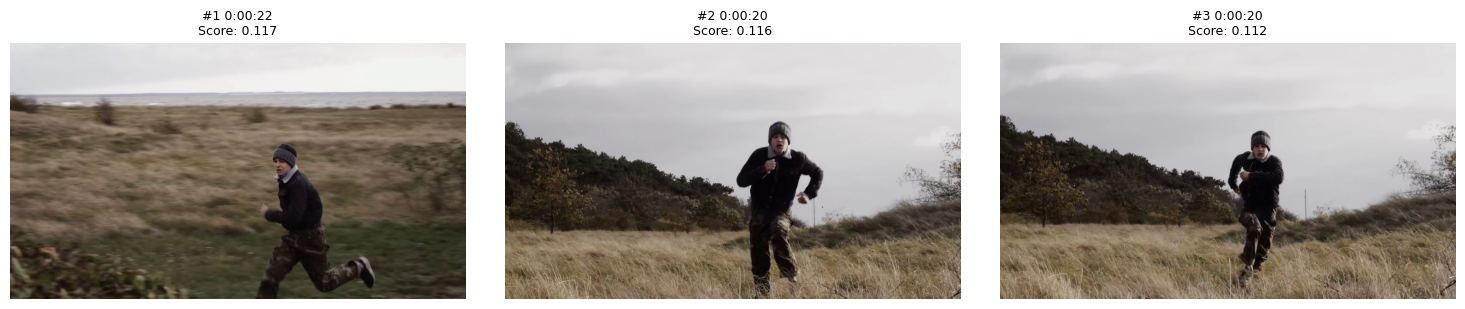

In [30]:
# Example search query - update this to match your video content
query = "running"

results = search(query, top_k=3)
display_search_results(results)

---

## Clean Up (Optional)

In [22]:
# Uncomment to clear all indexed data
# clear_database()

---

## Summary

This notebook implements a complete **multimodal semantic search pipeline** supporting videos, images, and documents.

### Video Search (SigLIP 2)

| Function | Description |
|----------|-------------|
| `extract_frames()` | Extract frames from video at configurable FPS |
| `embed_images()` | Generate 768-dim SigLIP 2 embeddings |
| `index_video()` | Full indexing pipeline |
| `search()` | Find matching frames |

### Image Search (SigLIP 2)

| Function | Description |
|----------|-------------|
| `load_image()` | Load and convert image to RGB |
| `index_image()` | Index a single image |
| `index_images_from_folder()` | Batch index images |

### Document Search (E5-small)

| Function | Description |
|----------|-------------|
| `extract_text()` | Extract text from .txt, .md, .pdf, .docx |
| `chunk_text()` | Split text into overlapping chunks |
| `embed_texts()` | Generate 384-dim E5 embeddings with query/passage prefixes |
| `index_document()` | Chunk, embed, and store document |
| `search_documents()` | Find matching document chunks |

### Unified Search

| Function | Description |
|----------|-------------|
| `unified_search()` | Search across all content types at once |

### Key Parameters

| Parameter | Value | Purpose |
|-----------|-------|---------|
| `MODEL_NAME` | `google/siglip2-base-patch16-224` | Vision-language encoder (768-dim) |
| `DOCUMENT_MODEL_NAME` | `intfloat/multilingual-e5-small` | Document encoder (384-dim, 100+ languages) |
| `SAMPLE_RATE` | `1.0` | Frames per second to extract |
| `CHUNK_SIZE` | `400` | Words per document chunk |

### Collections

| Collection | Content | Embedding Model |
|------------|---------|-----------------|
| `visual_content` | Videos + Images | SigLIP 2 |
| `documents` | Text documents | E5-small |